# Статистический анализ данных сервиса аренды самокатов GoFast

Нам дали задание проанализировать популярный сервис аренды самокатов GoFast на основе данных о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализируовать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:

   без подписки:
абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;
    
с подпиской Ultra:
абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

Исходные данные по файлам.

Пользователи — ‘users_go.csv’:

‘user_id’ — уникальный идентификатор пользователя;

‘name’ — имя пользователя;

‘age’ — возраст;


‘city’ — город;

‘subscription_type’ — тип подписки (free, ultra).

Поездки — ‘rides_go.csv’:

user_id’ — уникальный идентификатор пользователя;

‘distance’ — расстояние, которое пользователь проехал в текущей сессии (в метрах);

‘duration’ — продолжительность сессии (в минутах);

‘date’ — дата совершения поездки.

Подписки — ‘subscriptions_go.csv’:

‘subscription_type’ — тип подписки;

‘minute_price’ — стоимость одной минуты поездки по данной подписке;

‘start_ride_price’ — стоимость начала поездки;

‘subscription_fee’ — стоимость ежемесячного платежа.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt 
from math import factorial
from scipy import stats as st

# импортируем необходимые для проекта библиотеки

### Загрузка данных.

In [2]:
data_users = pd.read_csv("/datasets/users_go.csv")
data_rides = pd.read_csv("/datasets/rides_go.csv")
data_subscriptions = pd.read_csv("/datasets/subscriptions_go.csv")
# загружаем предотавленые таблицы

In [3]:
data_users.head(5) # открываем таблицы

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
data_rides.head(5) # открываем таблицы

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
data_subscriptions.head(5) # открываем таблицы

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
data_users.info() # смотрим общую информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
data_rides.info()# смотрим общую информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
data_subscriptions.info() # смотрим общую информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Вывод. Загрузили и просмотрели данные, пропуски в данных отсутствуют,  в дальнейшем проверим данные на дубликаты и выбивающиеся значения. Названия столбцов соответствуют "змеинному стилю".

###  Предобработка данных

In [9]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d') #меняем формат даты

In [10]:
data_rides["month_of_ride"] = data_rides['date'].dt.month # добавляем столбец с номером месяца публикации

In [11]:
data_rides.head(3) # проверяем что получилось, выведя первые строки

,user_id,distance,duration,date,month_of_ride
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4


In [12]:
data_rides['distance'] = data_rides['distance'].round(2) 
data_rides.head(5)
# округляем данные в графе "Дистанция"

,user_id,distance,duration,date,month_of_ride
0,1,4409.92,25.599769,2021-01-01,1
1,1,2617.59,15.816871,2021-01-18,1
2,1,754.16,6.232113,2021-04-20,4
3,1,2694.78,18.511000,2021-08-11,8
4,1,4028.69,26.265803,2021-08-28,8


In [13]:
data_users.isna().sum() # проверяем таблицу на наличие пропусков

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
data_users.duplicated().sum() # проверяем таблицу на наличие явных дубликатов

31

In [15]:
data_users["user_id"].duplicated().sum() # проверяем столбец на наличие явных дубликатов

31

In [16]:
data_users.drop_duplicates(inplace=True)  # удаляем явные дубликаты

In [17]:
data_users["user_id"].duplicated().sum()  # повторно проверяем столбец на наличие явных дубликатов

0

In [18]:
data_rides.isna().sum()  # проверяем таблицу на наличие пропусков

user_id          0
distance         0
duration         0
date             0
month_of_ride    0
dtype: int64

In [19]:
data_rides.duplicated().sum() # проверяем таблицу на наличие явных дубликатов

0

In [20]:
data_subscriptions.isna().sum()  # проверяем таблицу на наличие пропусков

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [21]:
data_subscriptions.duplicated().sum() # проверяем таблицу на наличие явных дубликатов

0

Округлили даннные по дистанции, привели столбец date к типу даты pandas, после чего создали новый столбец с номером месяца на основе столбца date.

Проверили таблицы на наличие дубликатов и пропусков. Дубликаты, которые повлияли бы на исследование - удалили

### Исследовательский анализ данных.

В этом разделе опишем и визуализируем общую информацию о пользователях и поездках

In [22]:
data_users["city"].unique() # смотрим клиенты каких городов представлены

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [23]:
data_users['city'].value_counts()# считаем в каких городах сколько клиентов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

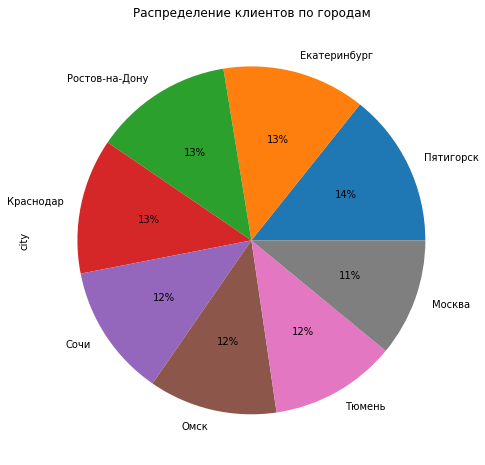

In [24]:
data_users["city"].value_counts().plot(kind = "pie",figsize=(8,8),\
                                       autopct = '%1.0f%%', title = 'Распределение клиентов по городам')
plt.show()

In [25]:
data_users['subscription_type'].value_counts() # проверяем какое количество поьзователей имееют подписку

free     835
ultra    699
Name: subscription_type, dtype: int64

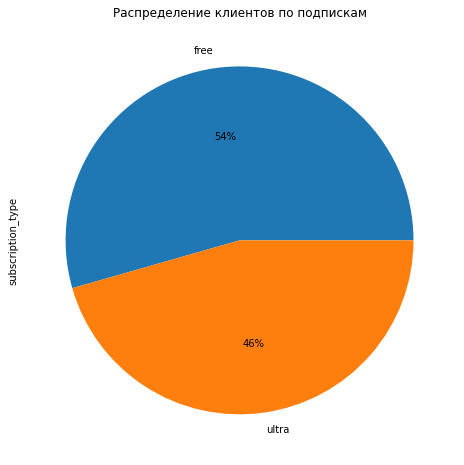

In [26]:
data_users["subscription_type"].value_counts().plot(kind = "pie",figsize=(8,8), autopct = '%1.0f%%',
                                                    title = 'Распределение клиентов по подпискам')
plt.show()

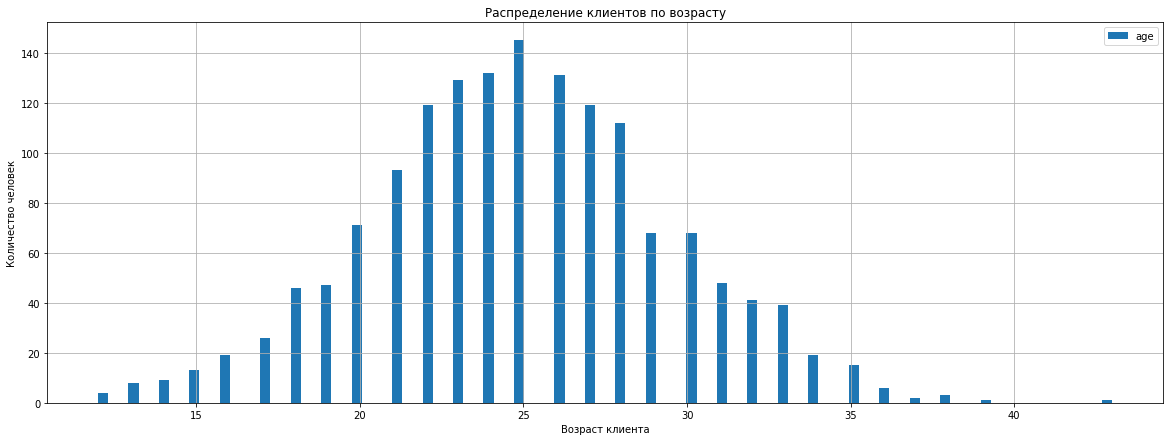

In [27]:
data_users.plot(kind = "hist", y = 'age', bins=100,  figsize=(20,7), grid = True, title = "Распределение клиентов по возрасту") 
plt.xlabel('Возраст клиента')
plt.ylabel('Количество человек')
plt.show()
# строим гистограмму значения возраста

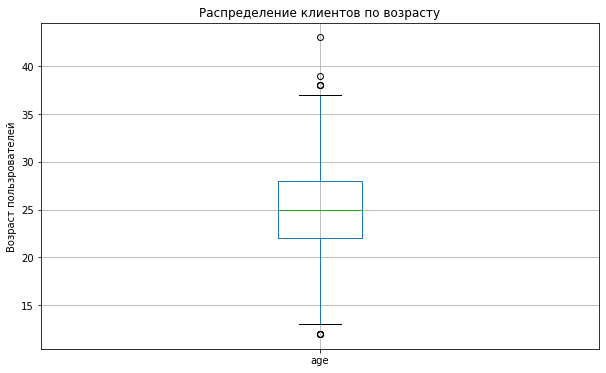

In [28]:
data_users.boxplot(column=['age'], figsize=(10,6), grid=True )
plt.ylabel('Возраст пользрователей')
plt.title("Распределение клиентов по возрасту")
plt.show()

# строим диаграмму размаха возраста пользователей

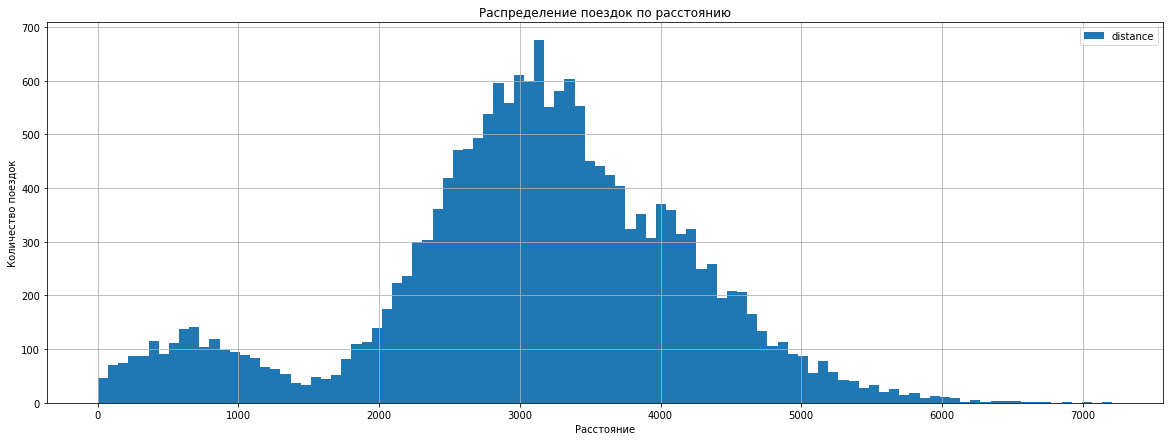

In [29]:
data_rides.plot(kind = "hist", y = "distance", bins=100,  figsize=(20,7), grid = True, title = "Распределение поездок по расстоянию") 
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()
# строим гистограмму расстояния поездок)

На данном графике видны два пика расстояния поездок. Основной пик составяет около 3100 м., пик малых поездок составляет около 700 м.

In [30]:
data_rides["distance"].describe() # смотрим распределение поездок по расстоянию

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

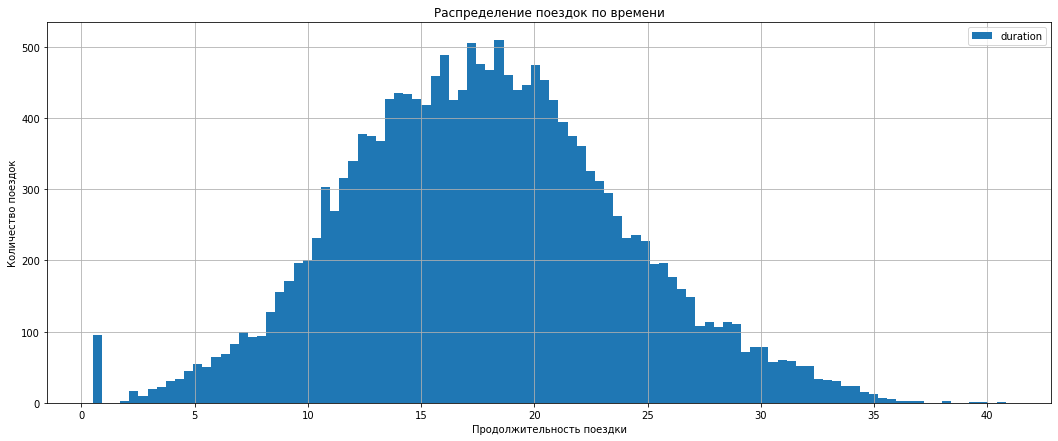

In [31]:
data_rides.plot(kind = "hist", y = "duration", bins=100,  figsize=(18,7), grid = True, title = "Распределение поездок по времени") 
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()
# строим гистограмму расстояния поездок)

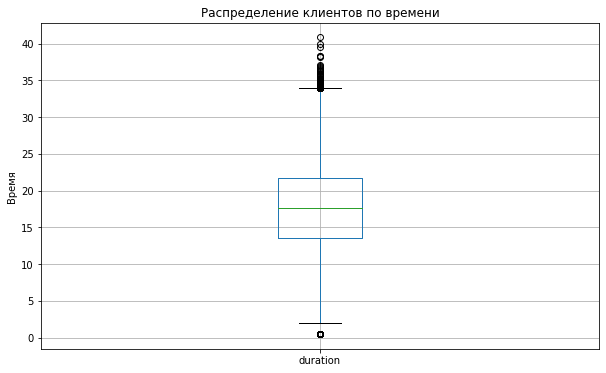

In [32]:
data_rides.boxplot(column=['duration'], figsize=(10,6), grid=True)
plt.ylabel('Время')
plt.title("Распределение клиентов по времени")
plt.show()

# строим диаграмму размаха времени поездок

In [33]:
data_rides["duration"].describe() # смотрим распределение поездок по времени

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Количество пользователей по городам не очень сильно отличается, но больше всего пользователей в Пятигорске, меньше всего в Москве. Большая часть пользователей не испольует платную подписку. Средний возраст пользователя - около 25 лет, но встерчаются изредка дети моложе 15 лет и взрослые старше 35. Клиенты в оснвоном берут самокат на время около 17 минут, за это время проезжая около 3000 метров. Встерчаются результаты нулевого расстояния, но это скорее всего из-за того, что пользователь передумал использовать самокат.

###  Объединение данных.

В этом разделе мы объединим данные о пользователях, поездках и подписках в один датафрейм. Создадим ещё два датафрейма из датафрейма, c данными о пользователях без подписки и с данными о пользователях с подпиской.
Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [34]:
data_users.shape[0] # проверяем количество строк перед объединением

1534

In [35]:
whole_data = data_users.merge(data_rides, on = "user_id", how = "left") 
# объединяем таблицу по столбцу User_id две таблицы

In [36]:
whole_data.head() # проверяем что получилось

,user_id,name,age,city,subscription_type,distance,duration,date,month_of_ride
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8


In [37]:
whole_data.shape[0] # проверяем количество строк после объединения

18068

In [38]:
whole_data= whole_data.merge(data_subscriptions) # добавляем третью таблицу к созданной

In [39]:
whole_data.head() # проверяем что получилось

,user_id,name,age,city,subscription_type,distance,duration,date,month_of_ride,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8,6,0,199


In [40]:
whole_data.shape[0] # проверяем количество строк после объединения

18068

In [41]:
print("Количество пользователей в таблицe 'data_users' составляет:", data_users["user_id"].count())
print("Количество уникальных пользователей в таблицe 'whole_data' составляет:", whole_data["user_id"].nunique())
whole_data.isna().sum()

Количество пользователей в таблицe 'data_users' составляет: 1534
Количество уникальных пользователей в таблицe 'whole_data' составляет: 1534


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month_of_ride        0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проверили новую таблицу на наличие пропусков. Таблицы совместились правильно

In [42]:
ultra_ride = whole_data.loc[whole_data['subscription_type'] == "ultra"] #создаем таблицу пользователей с абонементом

In [43]:
free_ride = whole_data.loc[whole_data['subscription_type'] == "free"] #создаем таблицу пользователей без абонемента

In [44]:
ultra_ride.head() # проверяем

,user_id,name,age,city,subscription_type,distance,duration,date,month_of_ride,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8,6,0,199


In [45]:
free_ride.head() # проверяем

,user_id,name,age,city,subscription_type,distance,duration,date,month_of_ride,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17.427673,2021-02-14,2,8,50,0


In [46]:
free_ride.shape[0]

11568

In [47]:
ultra_ride.shape[0]

6500

In [48]:
ultra_ride["distance"].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

In [49]:
free_ride["distance"].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

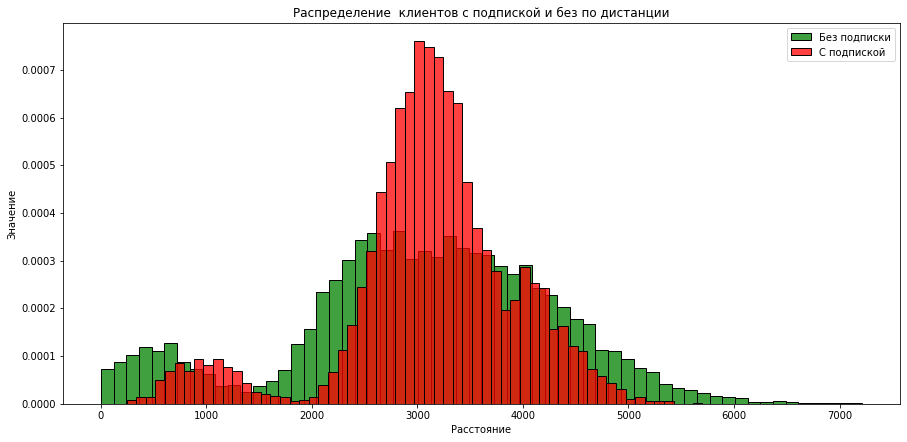

In [50]:
plt.figure(figsize=(15,7))
sns.histplot(free_ride['distance'], stat='density',  common_norm=False, bins = 60, color='Green');
sns.histplot(ultra_ride['distance'],   stat='density', common_norm=False, bins = 60, color='Red');
plt.legend(['Без подписки', 'С подпиской']);
plt.title('Распределение  клиентов с подпиской и без по дистанции')
plt.xlabel('Расстояние');
plt.ylabel('Значение');
plt.show();
# строим гистограмму расстояния поездок

In [51]:
ultra_ride["duration"].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [52]:
free_ride["duration"].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

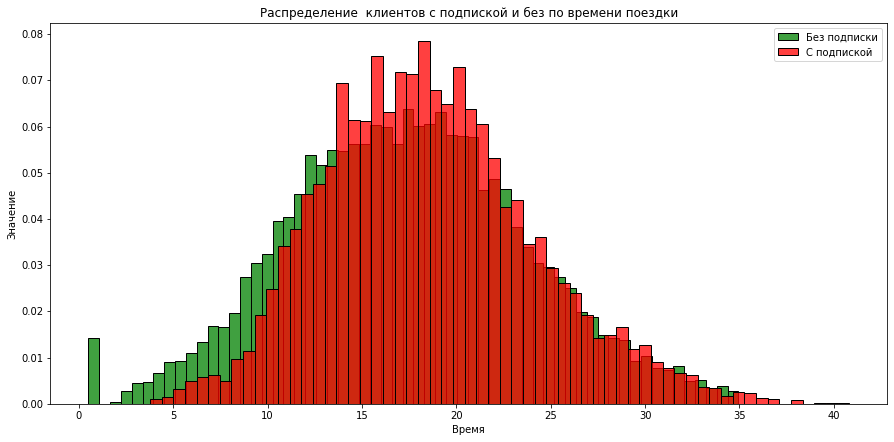

In [53]:
plt.figure(figsize=(15,7))
sns.histplot(free_ride['duration'], stat='density',  common_norm=False, bins = 60, color='Green');
sns.histplot(ultra_ride['duration'],   stat='density', common_norm=False, bins = 60, color='Red');
plt.legend(['Без подписки', 'С подпиской']);
plt.title('Распределение  клиентов с подпиской и без по времени поездки')
plt.xlabel('Время');
plt.ylabel('Значение');
plt.show();
# строим гистограмму времени  поездок

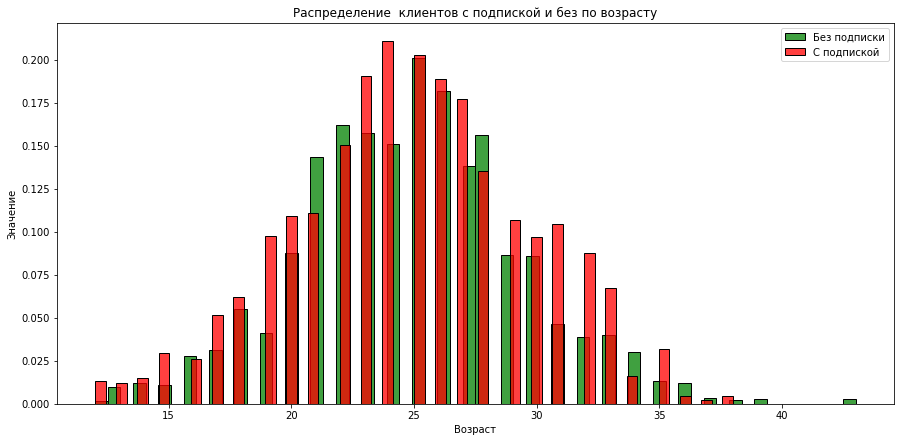

In [54]:
plt.figure(figsize=(15,7))
sns.histplot(free_ride['age'], stat='density',  common_norm=False, bins = 60, color='Green');
sns.histplot(ultra_ride['age'],   stat='density', common_norm=False, bins = 60, color='Red');
plt.legend(['Без подписки', 'С подпиской']);
plt.title('Распределение  клиентов с подпиской и без по возрасту')
plt.xlabel('Возраст');
plt.ylabel('Значение');
plt.show();
# строим гистограмму возраста

Объединили данные о пользователях. Количество поездок, совершенных с подпиской составяет 6500 против 11568 без подписки. Возраст пользователей с подпиской и без распределен одинаково. При рассмотрении данных о расстоянии поездок у пользовтелей с подпиской поездка в среднем составляет около 3100, без подписки - около 3000. Также у пользователей на графиках видны всплески коротких поездок - около 1000 м с подпиской и около 700 м. без подписки. По времени пользования распределение практически одинаковое - в основном от 15 до 20 минут

###  Подсчёт выручки.

В этом разделе создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными, найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Потом В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь.

In [55]:
whole_data["duration"] = np.ceil(whole_data["duration"]) 
# округляем значения "duration" в совмещенной таблице в большую сторону

In [56]:
whole_data.head(3) # проверяем

,user_id,name,age,city,subscription_type,distance,duration,date,month_of_ride,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,6,0,199


In [57]:
revenue_data = pd.pivot_table(whole_data,
                           index=['month_of_ride', 'user_id'],
                           values = ['distance', 'duration', "name", 'subscription_type'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum,
                                     'name' : len,
                                     'subscription_type' : min})
# создаем таблицу с необходимыми для подсчета выручки столбцами

In [58]:
revenue_data = revenue_data.rename(columns = {"name": "counts_of_trips"}) 
# переименовываем столбец "name" в "counts_of_trips"

In [59]:
revenue_data.head(3) # проверяем

distance  duration  counts_of_trips subscription_type
month_of_ride user_id                                                       
1             1         7027.51      42.0                2             ultra
              3         3061.78      13.0                1             ultra
              5         3914.65      13.0                1             ultra

In [60]:
def profit(line):
    if line ["subscription_type"] == "ultra":
        return 6*line ["duration"]+199
    elif line ["subscription_type"] == "free":
        return 8*line ["duration"]+50*line["counts_of_trips"]

    # расчитываем  выручку в соответсвии с категорией пользователей        

In [61]:
revenue_data["profit_month"] = revenue_data.apply(profit, axis = 1) 
# добавляем столбец с помесячной выручкой для каждого пользователя

In [62]:
revenue_data # проверяем полученные даные

distance  duration  counts_of_trips subscription_type  \
month_of_ride user_id                                                          
1             1         7027.51      42.0                2             ultra   
              3         3061.78      13.0                1             ultra   
              5         3914.65      13.0                1             ultra   
              7         6478.08      28.0                2             ultra   
              12        3577.15      33.0                1             ultra   
...                         ...       ...              ...               ...   
12            1525      4597.85      34.0                1              free   
              1526      3644.12      23.0                1              free   
              1528      3998.57      11.0                1              free   
              1532      6111.89      42.0                2              free   
              1534      2371.71      16.0                1              free   

                       profit_month  
month_of_ride user_id                
1             1               451.0  
              3               277.0  
              5               277.0  
              7               367.0  
              12              397.0  
...                             ...  
12            1525            322.0  
              1526            234.0  
              1528            138.0  
              1532            436.0  
              1534            178.0  

[11331 rows x 5 columns]

Создали новый датафрейм. Нашли суммарное расстояние и время, количество поездок  помесячно для каждого пользователя. Добавили столбец с помесячной выручкой, которую принес каждый пользователь компании.    

###  Проверка гипотез.

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

Проверим гипотезу: 

H-0: Пользователи с подпиской и без подписки трятят одинаковое время на поездки.

H-1: Пользователи с подпиской тратят больше времени на поездки.

In [63]:
alpha = 0.05 # уровень значимости

In [64]:
results = st.ttest_ind(ultra_ride['duration'], free_ride['duration'],alternative = 'greater')
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


Вывод: Отвергаем нулевую гипотезу, так как пользователи с подпиской тратят больше времени на поездки

 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Проверим гипотезу

Н-0 Пользователи с подпиской проезжают 3130 метров

Н-1 Пользователи с подпиской проезжают более 3130 метров

In [65]:
alpha = 0.05 # уровень значимости

In [66]:
results = st.ttest_1samp(ultra_ride ["distance"], 3130, alternative='greater')
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

0.9195362605842414
Не отвергаем нулевую гипотезу


Вывод. Гипотезу проверили. Не отвергаем гипотезу о том что пользователи с подпиской проезжают расстояние менее или равное 3130 м.

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.

Н-0 Выручка в месяц у пользователей с подпиской = выручке от пользователей без подписки.

Н-1 Выручка в месяц у пользователей с подпиской выше, чем у пользователей без подписки.

In [67]:
ultra_cost = revenue_data.loc[revenue_data.subscription_type == "ultra", "profit_month"]
free_cost = revenue_data.loc[revenue_data.subscription_type == "free", "profit_month"]

In [68]:
results = st.ttest_ind(ultra_cost, free_cost, alternative = 'greater')
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


### Вывод.

Пользователи с подпиской приносят больше прибыли

Проведено исследование данных о пользователях сервиса аренды самоката и проверены гипотезы. В предоставленных данных не было пропущенных значений, но было незначительное количество дубликатов, которые были удалены. В дальнейшем три таблицы были объединены в одну. 

Было выявлено, что пользователями являются граждане в возрасте от 12 до 43 лет из 8 городов. Больше всего пользователей находится в городе Пятигорске, меньше всего в Москве. Так как сервис самокатов предоставляет услуги подписки, то интересно это распределение. Пользователей с подпиской 699 человек, против 835 без подписки. 

Пользователи самокатов за поездку проезжают до 7000 метров. В распределении поездок по расстоянию наблюдается два пика.  С подпиской в среднем чуть больше - 3100, без подписки поменьше - 3000 м. а также заметно пики малых поездок 700 м. без подписки и около 1000м с подпиской. 
По времени распределение поездок - нормальное - до 40 минут, в среденем от 15 до 20. Всего же поездок с подпиской почти в два раза меньше, чем поездок без подписок 6500 против 11568. 

Возраст на наличие подписки - не влияет. В данных встерчаются - аномально низкие значения по времени и расстоянию поездки - это, скоре всего, связано с тем, что пользователь передумал использовать самокат. 

При проверке гипотез мы отвергли гипотезу, что выручка от пользователей с подпиской равна выручке от пользователей без подписки. Не отвергли гипотезу, что пользователи с подпиской проезжают 3130 м. А также отвергли гипотезу, что клиенты с подпиской и без подписки тратят одинаковое время на поездки. 

Таким образом, по результатам исследования мы пришли к выводу, что пользователи с подпиской более выгодны компании, соответсвенно необходимо продвигать подписку.